In [17]:
!pip install arviz
!pip install pymc3

In [18]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
import math
from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [34]:
#Load and preprocess data

def get_process_data(url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv',
                     regions = ['British Columbia', 'Alberta','Saskatchewan','Manitoba','Ontario','Quebec']):
  """Loads data from source to dataframe & preprocess it"""
  # Select provinces with population > 1 million
  data = pd.read_csv(url,
                     usecols=['date', 'prname', 'numtotal'],
                     parse_dates=['date'],
                     index_col=['prname', 'date'],
                     squeeze=True).sort_index()



  idx = pd.IndexSlice
  data = data.loc[idx[regions,:]]
  return data

def process_covidtracking_data(data: pd.DataFrame):
  """Process raw data before feeding into the generative model"""
  #Set date as index
  data = data.set_index(["location","date"]).sort_index()
  #Remove all columns except 'total_cases', 'total_tests'
  data = data[['total_cases', 'total_tests']]
  #Handle missing values
  data.dropna(subset = ['total_cases', 'total_tests'], inplace = True)
  return data



In [35]:
data = get_process_data()

In [36]:
#Prepare cases

def prepare_cases(cases, cutoff = 10):
  new_cases = cases.diff()

  smoothed = new_cases.rolling(7, win_type = 'gaussian', min_periods = 1, center = True).mean(std = 2).round()
  idx_start = np.searchsorted(smoothed, cutoff)
  smoothed = smoothed.iloc[idx_start:]
  original = new_cases.loc[smoothed.index]

  return original, smoothed

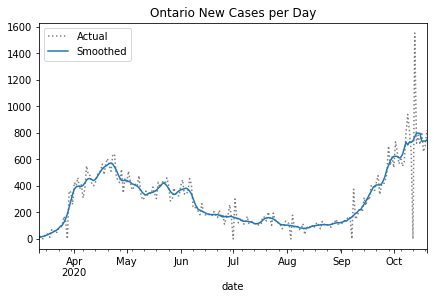

In [37]:



country_name = 'Ontario'

cases = data.xs(country_name).rename(f"{country_name} cases")
original, smoothed = prepare_cases(cases)

original.plot(title=f"{country_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
               figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')


In [23]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
def get_posteriors(sr, sigma = 0.15):
  # Calculate Lambda
  lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))  #######################%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%sr[:-1]>>sr[1:]
  #print('lam: ',lam.shape)

  #Calculate each days likelihood
  likelihoods = pd.DataFrame(data = sps.poisson.pmf(sr[1:], lam),
                             index = r_t_range,
                             columns = sr.index[1:])
  #print('likelihoods: ',likelihoods.shape)
  
  # Create Gaussian and normalize
  process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

  process_matrix /= process_matrix.sum(axis=0)

  # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
  prior0 = np.ones_like(r_t_range)/len(r_t_range)
  prior0 /= prior0.sum()

  # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
  posteriors = pd.DataFrame(
      index=r_t_range,
      columns=sr.index,
      data={sr.index[0]: prior0}   
    )   #######################%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%index[0]>>index[1]

  # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
  log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
  for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
      current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
      numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
      denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
      posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
      log_likelihood += np.log(denominator)
    
  return posteriors, log_likelihood




lam:  (1201, 222)
likelihoods:  (1201, 222)


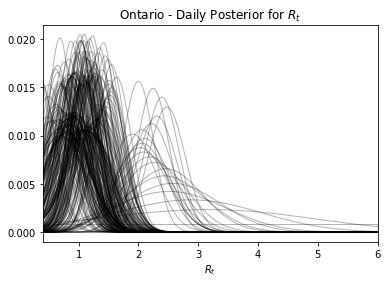

In [24]:
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)


ax = posteriors.plot(title=f'{country_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');



In [25]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])


# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-10-16,1.02,0.67,1.32
2020-10-17,0.69,0.32,0.98
2020-10-18,0.87,0.51,1.18
2020-10-19,0.95,0.58,1.25
2020-10-20,1.03,0.66,1.33


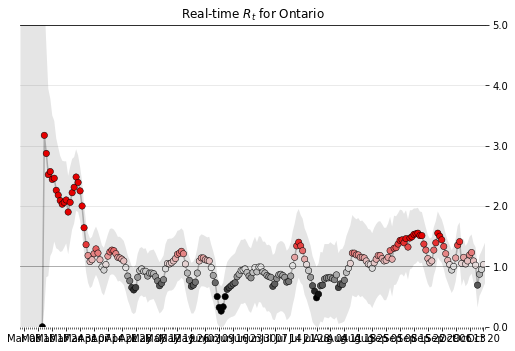

In [26]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, country_name)
ax.set_title(f'Real-time $R_t$ for {country_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [27]:
sigmas = np.linspace(1/20, 1, 20)
results = {}
for region_name, cases in data.groupby(level='prname'):
    
    print(region_name)
    new, smoothed = prepare_cases(cases, cutoff=10)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=10)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
      posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
      result['posteriors'].append(posteriors)
      result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[region_name] = result
    clear_output(wait=True)

print('Done.')

Done.


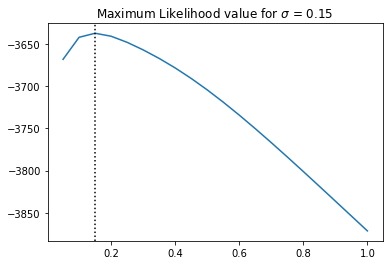

In [28]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [29]:


final_results = None

for region_name, result in results.items():
    print(region_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')



Done.


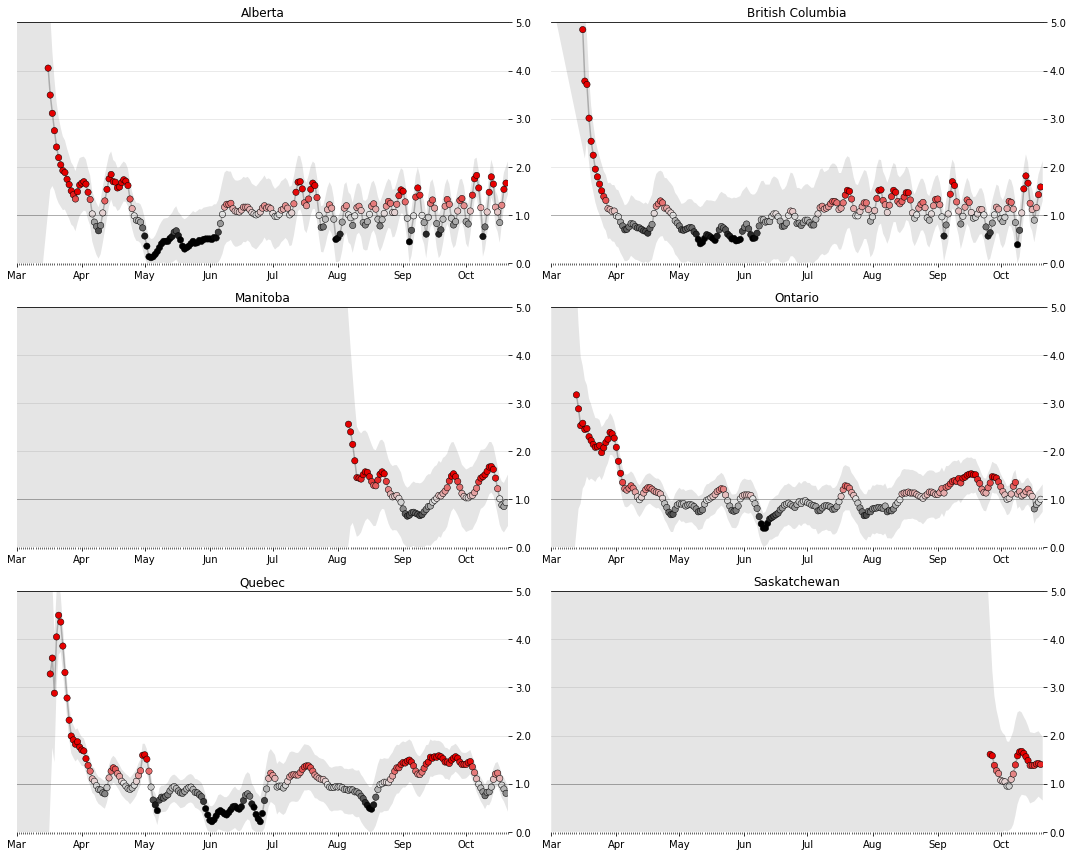

In [33]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))

for i, (region_name, result) in enumerate(final_results.groupby('prname')):
    plot_rt(result.iloc[1:], axes.flat[i], region_name)

fig.tight_layout()
fig.set_facecolor('w')
